## Basic Modules

Large hybrid UNet + GravNet model, built from pre-activation residual blocks with squeeze-excitation, up-sampling uses blurred pixel-shuffle.
Centre of UNet is replaced by GravNet layers considering each voxel as a node in a graph, and learns new latent-space representation based on other voxels clustered in latent-space.
Data augmentation provides four 90* rotations in xy plane, and a flip in the y axis, producing 7 extra copies of each volume. This is used during training and testing
An ensemble of 5 models is used, each trained for 100 epochs.

IOU ~= 0.821

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import h5py
import pickle
from typing import *
from functools import partial
from pathlib import Path
import sparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from fastprogress import progress_bar, master_bar
from fastcore.all import store_attr

from lumin.data_processing.file_proc import *
from lumin.nn.data.fold_yielder import *
from lumin.nn.data.fold_yielder import FoldYielder
from lumin.optimisation.hyper_param import lr_find
from lumin.nn.callbacks.cyclic_callbacks import *
from lumin.nn.metrics.eval_metric import EvalMetric
from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
from lumin.nn.models.blocks.body import *
from lumin.nn.models.helpers import CatEmbedder
from lumin.nn.models.blocks.head import *
from lumin.nn.models.blocks.head import AbsHead, AbsMatrixHead
from lumin.nn.models.blocks.tail import *
from lumin.nn.models.initialisations import lookup_normal_init
from lumin.nn.models.layers.activations import lookup_act
from lumin.nn.models.layers.batchnorms import *
from lumin.nn.training.train import train_models
from lumin.nn.models.blocks.conv_blocks import *
from lumin.nn.ensemble.ensemble import Ensemble
from lumin.nn.models.blocks.gnn_blocks import *
from lumin.nn.models.layers.self_attention import SelfAttention, OffsetSelfAttention

import torch
from torch import nn, Tensor
import torch.nn.functional as F

In [3]:
GPUID = 1

In [4]:
torch.cuda.set_device(GPUID)

In [5]:
PATH = Path(f'../data_{GPUID}/')

In [6]:
FULL = True

## Loading

In [ ]:
RAWPATH = Path(f'../data/')

In [ ]:
h5 = h5py.File(RAWPATH/'train.h5', 'r')

In [ ]:
h5['targs'].shape

In [ ]:
n_train = int(0.8*h5['targs'].shape[0])

In [ ]:
train_x = h5['x0'][:n_train]
train_y = h5['targs'][:n_train]
valid_x = h5['x0'][n_train:]
valid_y = h5['targs'][n_train:]

In [ ]:
train_x.shape, valid_y.shape

In [ ]:
h5.close()

In [ ]:
with h5py.File(RAWPATH/'test.h5', 'r') as h5:
    test_x = h5['x0'][()]

## Preproc

In [ ]:
mean = train_x.mean()
std = train_x.std()

In [ ]:
mean, std

In [ ]:
train_x -= mean
valid_x -= mean
test_x -= mean

In [ ]:
train_x /= std
valid_x /= std
test_x /= std

In [ ]:
test_x.mean(), test_x.std()

## Saving

In [ ]:
train_y.shape

In [ ]:
train_y.reshape(len(train_y), 1000).shape

In [ ]:
def to_ff(out_name:str, x0:np.ndarray, targs:np.ndarray, as_sparse:bool, n_folds:int=10) -> None:
    df2foldfile(df=None, n_folds=n_folds,
                targ_feats='gen_target', savename=out_name, targ_type='int', tensor_target=targs.reshape(len(targs), -1),
                cont_feats=[], cat_feats=[], tensor_data=x0[:,None], tensor_name='x0', compression='lzf', tensor_target_as_sparse=as_sparse)

In [ ]:
to_ff(PATH/'train_lumin_full', train_x, train_y, as_sparse=True)

In [ ]:
to_ff(PATH/'valid_lumi_full', valid_x, valid_y, as_sparse=True)

In [ ]:
to_ff(PATH/'test_lumin', test_x, test_x, as_sparse=True)

## Load data

Class below handles data loading, and can either provide random or fixed augmentation when loading batches

In [7]:
class AugFoldYielder(FoldYielder):
    def __init__(self, foldfile:Union[str,Path,h5py.File], cont_feats:Optional[List[str]]=None, cat_feats:Optional[List[str]]=None,
                 ignore_feats:Optional[List[str]]=None,
                 train_time_aug:bool=True, test_time_aug:bool=True,
                 input_pipe:Optional[Pipeline]=None, output_pipe:Optional[Pipeline]=None,
                 yield_matrix:bool=True, matrix_pipe:Optional[Union[str,Pipeline]]=None):
        super().__init__(foldfile=foldfile, cont_feats=cont_feats, cat_feats=cat_feats,
                         ignore_feats=ignore_feats, input_pipe=input_pipe, output_pipe=output_pipe,
                         yield_matrix=yield_matrix, matrix_pipe=matrix_pipe)

        self.train_time_aug,self.test_time_aug = train_time_aug,test_time_aug
        self.augmented,self.aug_mult = True,8
        
    def _rotate(self, x0:np.ndarray, targ:np.ndarray, rot:int) -> Tuple[np.ndarray, np.ndarray]:
        x0 = np.rot90(x0, rot, (-1,-2))
        targ = np.rot90(targ, rot, (-1,-2))
        return x0, targ
    
    def _flip_x(self, x0:np.ndarray, targ:np.ndarray) -> Tuple[np.ndarray, np.ndarray]: 
        x0 = np.flip(x0, -2)
        targ = np.flip(targ, -2)
        return x0, targ
            
    def get_fold(self, idx:int) -> Dict[str,np.ndarray]:
        fold = super().get_fold(idx)
        
        x0 = fold['inputs'][1]
        targ = fold['targets'].reshape(x0.shape)
        
        x0, targ = self._rotate(x0, targ, np.random.randint(4))
        if np.random.rand(1) >= 0.5: x0, targ = self._flip_x(x0, targ)
            
        fold['inputs'] = (fold['inputs'][0],x0.copy())
        fold['targets'] = targ.reshape(len(x0), -1).copy()
        return fold
    
    def get_test_fold(self, idx:int, aug_idx:int) -> Dict[str, np.ndarray]:
        if aug_idx >= self.aug_mult: raise ValueError(f"Invalid augmentation idx passed {aug_idx}")
        fold = super().get_fold(idx)
        
        x0 = fold['inputs'][1]
        targ = fold['targets'].reshape(x0.shape)
        
        x0, targ = self._rotate(x0, targ, aug_idx%4)
        if aug_idx >= 4: x0, targ = self._flip_x(x0, targ)
            
        fold['inputs'] = (fold['inputs'][0],x0.copy())
        fold['targets'] = targ.reshape(len(x0), -1).copy()
        return fold

In [8]:
train_fy = AugFoldYielder(PATH/f'train{"_lumin_full.hdf5" if FULL else "_lumin.hdf5"}')

In [9]:
train_fy.foldfile['fold_0']['targets']

<HDF5 dataset "targets": shape (3, 575474), type "<i8">

## Model Building

No 3D pixel shuffle in PyTorch, therefore make own

In [10]:
class PixelShuffle1d(nn.Module):
    def __init__(self, upscale_factor: int):
        ''' Based on https://github.com/gap370/pixelshuffle3d/blob/master/pixelshuffle3d.py'''
        super().__init__()
        self.upscale_factor = upscale_factor
        
    def forward(self,  x:Tensor) -> Tensor:
        b,cin,xin = x.size()
        cout,xout = cin//self.upscale_factor,xin*self.upscale_factor
        x = x.reshape(b, cout, self.upscale_factor, xin)
        x = x.permute(0,1,3,2)
        return x.reshape(b,cout,xout)

In [11]:
class PixelShuffle2d(nn.Module):
    def __init__(self, upscale_factor: int):
        ''' Based on https://github.com/gap370/pixelshuffle3d/blob/master/pixelshuffle3d.py'''
        super().__init__()
        self.upscale_factor = upscale_factor
        
    def forward(self,  x:Tensor) -> Tensor:
        b,cin,xin,yin = x.size()
        cout,xout,yout = cin//(self.upscale_factor**2),xin*self.upscale_factor,yin*self.upscale_factor
        x = x.reshape(b, cout, self.upscale_factor, self.upscale_factor, xin, yin)
        x = x.permute(0,1,4,2,5,3)
        return x.reshape(b,cout,xout,yout)

In [12]:
class PixelShuffle3d(nn.Module):
    def __init__(self, upscale_factor: int):
        ''' Based on https://github.com/gap370/pixelshuffle3d/blob/master/pixelshuffle3d.py'''
        super().__init__()
        self.upscale_factor = upscale_factor
        
    def forward(self,  x:Tensor) -> Tensor:
        b,cin,zin,xin,yin = x.size()
        cout,zout,xout,yout = cin//(self.upscale_factor**3),zin*self.upscale_factor,xin*self.upscale_factor,yin*self.upscale_factor
        x = x.reshape(b, cout, self.upscale_factor, self.upscale_factor, self.upscale_factor, zin, xin, yin)
        x = x.permute(0,1,5,2,6,3,7,4)
        return x.reshape(b,cout,zout,xout,yout)

In [13]:
x = torch.rand(1,8,4,4)
assert (nn.PixelShuffle(2)(x) == PixelShuffle2d(2)(x)).all()

Custom UNet based on pre-activation residual blocks, with optional squeeze-excitation and depth encoding, centre replaced with GravNet

In [14]:
class UNetGNN(AbsMatrixHead):
    def __init__(self, *, shape:Tuple[int], act:str='swish', bn:bool=False, do:Optional[float]=None,
                 # Unet options
                 n_filters:int=16, ks_init:int=3, n_res_per_size:int=2, se_net_r:Optional[float]=None,
                 encode_depth:bool=False, bn_class:Callable[[int],nn.Module]=nn.BatchNorm3d,
                 
                 # GNN options
                 cat_means: bool = True,
                 n_s: int,
                 f_slr_depth: int,
                 k: int,
                 n_lr: int,
                 f_out_depth: int,
                 use_sa: bool,
                 n_out: Union[List[int], int],
                 gnn_bn:bool,                 
                 
                 # General options
                 bn1d_class: Callable[[int], nn.Module] = nn.BatchNorm1d,
                 sa_class: Callable[[int], nn.Module] = SelfAttention,
                 lookup_init:Callable[[str,Optional[int],Optional[int]],Callable[[Tensor],None]]=lookup_normal_init,
                 lookup_act:Callable[[str],Any]=lookup_act, freeze:bool=False, **kwargs):
        r'''
        Inherits from abstract LUMIN head block for matrix data
        
        Arguments:
            shape: c,z,x,y shape of tensor to expect (no batch dim)
            act: activation function to use
            bn: whether to use batchnorm
            do: dropout probabibilty (not implemented)
            
            n_filters: basis for number of channels in each level
            ks_init: kernal size for initial conv layer
            n_res_per_size: number of residual blocks per downsampling/upsampling stage
            se_net_r: reduction coef for squeeze excitation blocks n_middle = n_in // r, None = no SE
            encode_depth: adds z-layer inidcator feature before first and last blocks
            
            cat_means: inputs to GravNet layers concatenated with means of features across nodes
            n_s: number of latent-spatial dimensions to compute
            f_slr_depth: number of layers to use for the latent rep. NN
            k: number of neighbours (including self) each vertex should consider when aggregating latent-representation features
            n_lr: number of features to compute per vertex for latent representation
            f_out_depth: number of layers to use for the output NN
            use_sa: if true, will apply self-attention layer to the neighbourhhood features per vertex prior to aggregation
            n_out: number of output features to compute per vertex
            gnn_bn: whether batch normalisation should be applied to hidden layers in the NNs
        '''
        
        super().__init__(cont_feats=[], vecs=[], feats_per_vec=[], lookup_init=lookup_init, lookup_act=lookup_act, freeze=freeze)
        store_attr(but=['lookup_init', 'lookup_act', 'freeze'])
        if self.do is not None: raise NotImplementedError('Implement Dropout')
        
        self.register_buffer('edges', self._get_edges())
        self._make_layers()
        self.out_sz = self.check_out_sz()
        if self.freeze: self.freeze_layers()
        self._map_outputs()
        
    def _make_layers(self) -> None:
        # 1,10 -> n_filters, 10
        self.input_block = nn.Sequential(self._get_conv_layer(2 if self.encode_depth else 1, self.n_filters, kernel_size=self.ks_init, preact=False),
                                         *[self.ResBlock(self.n_filters, self.n_filters, parent=self)
                                           for _ in range(self.n_res_per_size)])
        # n_filters, 10 -> 2*n_filters, 5
        self.down_block_1 = nn.Sequential(self.ResBlock(self.n_filters, self.n_filters*2, stride=2, parent=self),
                                          *[self.ResBlock(self.n_filters*2, self.n_filters*2, parent=self)
                                            for _ in range(self.n_res_per_size-1)])
        self.rep_bn = nn.BatchNorm3d((self.n_filters*2)+3)
        self.gnn = GravNet(
            n_v=125,
            n_fpv=(self.n_filters*2)+3,
            cat_means=self.cat_means,
            f_slr_depth=self.f_slr_depth,
            n_s=self.n_s,
            n_lr=self.n_lr,
            k=self.k,
            f_out_depth=self.f_out_depth,
            n_out=self.n_out,
            act=self.act,
            use_sa=self.use_sa,
            sa_class=self.sa_class,
            agg_methods=["mean", "absmax"],
            bn=self.gnn_bn,
            bn_class=self.bn1d_class
        )     
        
        # collapse rep, 5 -> n_filters, 10
        self.up_block_1 = nn.Sequential(self.PixelShuffleUpConv(self.gnn.get_out_size()[1], pad=True, parent=self),
                                        self.ResBlock((self.gnn.get_out_size()[1]//2)+self.n_filters, self.n_filters, parent=self),
                                        *[self.ResBlock(self.n_filters, self.n_filters, parent=self)
                                          for _ in range(self.n_res_per_size-1)])
        self.output_block = nn.Sequential(self._get_conv_layer(self.n_filters+1 if self.encode_depth else self.n_filters, 1, preact=True, bias=True),
                                          nn.Sigmoid())
        self.lookup_init('sigmoid')(self.output_block[0][-1].weight)
        
    class ResBlock(nn.Module):
        def __init__(self, nin:int, nout:int, parent:'UNet', stride:int=1):
            super().__init__()
            self._get_conv,self._get_conv_layer = parent._get_conv,parent._get_conv_layer
            self.act,self.bn,self.bn_class = parent.act,parent.bn,parent.bn_class,
            self.lookup_act,self.lookup_init = parent.lookup_act,parent.lookup_init
            
            self.conv_path = self._get_conv_path(nin, nout, stride, parent.se_net_r)
            self.shortcut = self._get_shortcut(nin, nout, stride) if stride != 1 or nin != nout else lambda x: x
            
        def _get_conv_path(self, nin:int, nout:int, stride:int, se_net_r:Optional[float]) -> nn.Sequential:  
            layers = [self._get_conv_layer(nin=nin, nout=nout, kernel_size=3, stride=stride, preact=True),
                      self._get_conv_layer(nin=nout, nout=nout, kernel_size=3, stride=1, preact=True)]
            if se_net_r is not None:
                layers.append(SEBlock3d(nout, se_net_r, act=self.act, lookup_init=self.lookup_init, lookup_act=self.lookup_act))
            return nn.Sequential(*layers)
            
        def _get_shortcut(self, nin:int, nout:int, stride:int) -> nn.Sequential:
            layers = [self.lookup_act(self.act)]
            if self.bn: layers.append(self.bn_class(nin))
            if stride != 1: layers.append(nn.AvgPool3d(3, stride=stride, padding=1, count_include_pad=False))
            if nin != nout: layers.append(self._get_conv(nin=nin, nout=nout, act=self.act, kernel_size=1, stride=1, bias=False))
            return nn.Sequential(*layers)
        
        def forward(self, x:Tensor) -> Tensor:
            return self.conv_path(x)+self.shortcut(x)
        
    class PixelShuffleUpConv(nn.Module):
        def __init__(self, nin:int, parent:'UNet', scale:int=2, pad:bool=True):
            super().__init__()
            self._get_conv,self._get_conv_layer = parent._get_conv,parent._get_conv_layer
            self.act,self.bn,self.bn_class = parent.act,parent.bn,parent.bn_class,
            self.lookup_act,self.lookup_init = parent.lookup_act,parent.lookup_init
            
            self.up_conv = self._get_layers(nin, scale, pad)
            
        def _get_layers(self, nin:int, scale:int, pad:bool) -> nn.Sequential:
            layers = [self._get_conv_layer(nin=nin, nout=nin*(scale**2), kernel_size=1, stride=1, preact=True),
                      PixelShuffle3d(scale)]
            if pad: layers.append(nn.ReplicationPad3d((1,0,1,0,1,0)))
            layers.append(nn.AvgPool3d(2, 1))
            return nn.Sequential(*layers)
            
        def forward(self, x:Tuple[Tensor,Tensor]) -> Tensor:
            x_up,x_skip = x[0],x[1]
            x_up = self.up_conv(x_up)
            return torch.cat((x_up, x_skip), dim=1)
                
    def _get_conv(self, nin:int, nout:int, act:str, kernel_size:int, stride:int, bias:bool) -> nn.Conv3d:
        c = nn.Conv3d(nin, nout, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, bias=bias)
        self.lookup_init(act)(c.weight)
        if bias: nn.init.zeros_(c.bias)
        return c
        
    def _get_conv_layer(self, nin:int, nout:int, kernel_size:int=3, stride:int=1, bias:bool=False, preact:bool=True) -> nn.Sequential:
        layers = []
        if preact:
            if self.bn: layers.append(self.bn_class(nin))
            layers.append(self.lookup_act(self.act))
        layers.append(self._get_conv(nin=nin, nout=nout, act=self.act, kernel_size=kernel_size, stride=stride, bias=bias))
        if not preact:
            layers.append(self.lookup_act(self.act))
            if self.bn: layers.append(self.bn_class(nout))
        return nn.Sequential(*layers)
    
    def _get_edges(self) -> Tensor:
        bounds = (
            np.mgrid[
                0 : 5 : 1,
                0 : 5 : 1,
                0 : 5 : 1,
            ]
        )
        edges = torch.tensor(bounds, dtype=torch.float32)
        edges = edges-edges.mean([1,2,3], keepdim=True)
        edges = edges/edges.std([1,2,3], keepdim=True)
        return edges
        
    def forward(self, x:Tensor) -> Tensor:
        x = self._process_input(x)
        
        if self.encode_depth:
            depth = torch.arange(x.shape[2], device=x.device, dtype=torch.float32)[None,None,:,None,None].expand_as(x)
            depth = depth-(x.shape[2]/2)
            depth = depth/depth.std()
            x = torch.cat((x,depth), dim=1)
        
        # Downsample
        input = self.input_block(x)  # 1, 10 -> n_filters, 10 
        down_1 = self.down_block_1(input)  # n_filters, 10 -> 2*n_filters, 5
        
        # GNN
        # input=(batch,x0,z,x,y)
        x = torch.cat((down_1, self.edges[None].expand(len(down_1), -1, -1, -1, -1)), dim=1)
        x = self.rep_bn(x)
        x = x.reshape(x.size(0),x.size(1),125).transpose(-1,-2)  # (volume,voxel,(c,z,x,y))
        
        x = self.gnn(x) # (volume,voxel,(c,z,x,y)) -> (volume,voxel,vox_rep)
        x = x.transpose(-1,-2).reshape(len(input), x.size(2), 5, 5, 5)
        
        # Upsample
        x = self.up_block_1((x, input)) # ?, 5 -> n_filters, 10
        if self.encode_depth:
            x = torch.cat((x,depth), dim=1)
        x = self.output_block(x)  # n_filters, 10 -> 1, 10
        return x.reshape(x.shape[0],-1)
    
    def _map_outputs(self) -> None:
        self.feat_map = {}
        for i, f in enumerate(self.cont_feats): self.feat_map[f] = list(range(self.get_out_size()))
            
    def check_out_sz(self) -> int:
        r'''
        Automatically computes the output size of the head by passing through random data of the expected shape

        Returns:
            x.size(-1) where x is the outgoing tensor from the head
        '''

        x = torch.zeros((1, *self.shape))
        training = self.training
        self.eval()
        x = self.forward(x)
        if training: self.train()
        return x.size(-1)
    
    def get_out_size(self) -> int:
        r'''
        Get size of output

        Returns:
            Width of output representation
        '''
        
        return self.out_sz

Use soft-IOU as loss function

In [15]:
class BinarySoftIOULoss(nn.Module):
    def __init__(self, use_square_sum:bool=False, smooth=1e-17):
        super().__init__()
        self.use_square_sum,self.smooth = use_square_sum,smooth
        
    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        inter = (input*target).sum(-1)Use soft-IOU as loss function
        union = input.square().sum(-1) if self.use_square_sum else input.sum(-1)
        union = union+target.sum(-1)-inter
        return 1-((inter+self.smooth)/(union+self.smooth)).mean()

Lumin model builder. Place entire model as the head block, body and tail blocks just pass input straight to output.

In [16]:
bs = 256 if FULL else 32
objective = 'classifier'

head = partial(UNetGNN,
               # UNet
               shape=train_fy.matrix_shape,
               bn=True,
               encode_depth=True,
               n_res_per_size=2 if FULL else 1,
               n_filters=32 if FULL else 4,
               se_net_r=4 if FULL else None,
               
               # GNN
               n_s=6,
               f_slr_depth=2,
               k=25,
               n_lr=25,
               f_out_depth=2,
               use_sa=True,
               n_out=[50, 50],
               gnn_bn=True,
               sa_class=OffsetSelfAttention,
#                bn1d_class=RunningBatchNorm1d,
              )
model_builder = ModelBuilder(objective, cont_feats=train_fy.cont_feats, n_out=1, cat_embedder=None, 
                             opt_args={'opt':'adam', 'eps':1e-08}, body=partial(IdentBody), head=head, tail=partial(IdentTail), loss=BinarySoftIOULoss)
print(Model(model_builder))

Inputs:
0 Continuous: []
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): UNetGNN(
    (input_block): Sequential(
      (0): Sequential(
        (0): Conv3d(2, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): Swish()
        (2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ResBlock(
        (conv_path): Sequential(
          (0): Sequential(
            (0): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): Swish()
            (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          )
          (1): Sequential(
            (0): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): Swish()
            (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stri

## Training

Optional LR Finder, but I just used 1e-4->1e-2 for all trainings

In [ ]:
lr_finder = lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e0], n_repeats=2)

In [16]:
def binary_iou(preds:np.ndarray, targs:np.ndarray, as_mean:bool=True, smooth:float=1e-17) -> float:
    r'''
    Assumes that preds and targs have a batch dimension, and no class dimension, i.e. (batch, z, x, y)
    If the batch dimesion is missing, e.g. your are computing the IOU for a single sample,
    add it with e.g. preds[None], targs[None]
    '''
    
    preds = preds.reshape(len(preds), 1, -1).astype(bool)
    targs = targs.reshape(len(targs), 1, -1).astype(bool)
    
    inter = (preds*targs).sum(-1)
    union = (preds+targs).sum(-1)
    iou = ((inter+smooth)/(union+smooth))  # Small epsilon in case of zero union

    if as_mean: iou = iou.mean() 
    return iou

IOU metric with thresholding. Should be similar to 1-loss.

In [18]:
class IOUMetric(EvalMetric):
    def __init__(self, cut:float=0.5, main_metric:bool=True):
        super().__init__(name='IOU', lower_metric_better=False)
        self.cut = cut
        
    def evaluate(self) -> float:
        df = self.get_df()
        return binary_iou(df[[p for p in df.columns if 'pred_' in p]].values>=self.cut, df[[t for t in df.columns if 'gen_target_' in t]].values)

OneCycle with cosine interpolation for the LR and momentum, warm-up from 1e-4 to 1e-2 over 5 epochs, decay from 1e-2 to zero over 45 epochs

In [19]:
n_epochs = 2*50 if FULL else 15
cb_partials = [partial(OneCycle, lengths=[5, n_epochs-5],lr_range=[1e-4, 1e-2], mom_range=[0.85, 0.95], interp='cosine')]
metric_partials = [IOUMetric]

Training model 1 / 5, Valid Index = 0, Train indices= [1, 2, 3, 4, 5, 6, 7, 8, 9]


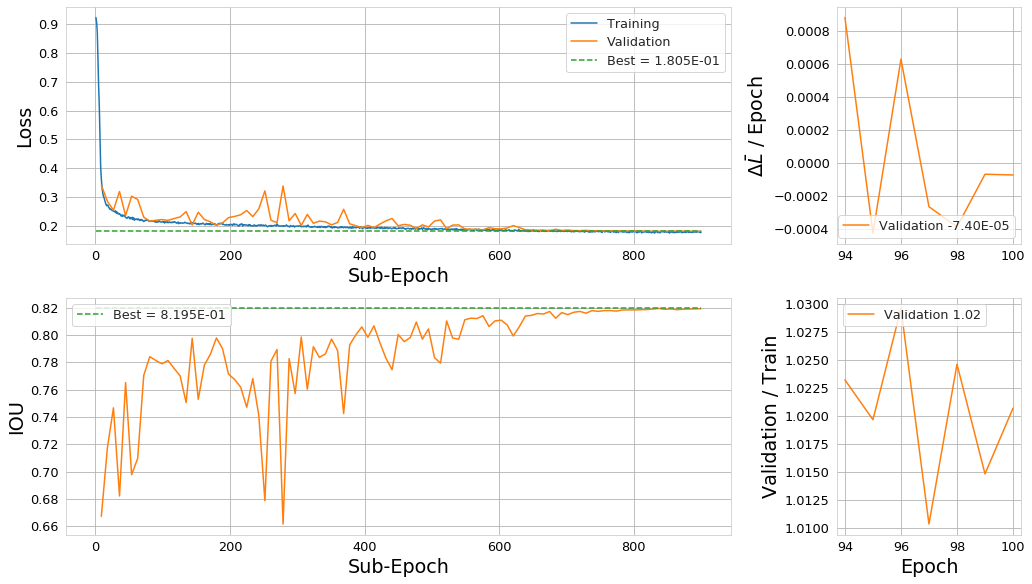

Loading best model with metric value -8.195E-01
Model took 5305.338s

Scores are: {'loss': 0.18054629949962392, 'IOU': 0.8195238827849273}
Training model 2 / 5, Valid Index = 1, Train indices= [0, 2, 3, 4, 5, 6, 7, 8, 9]


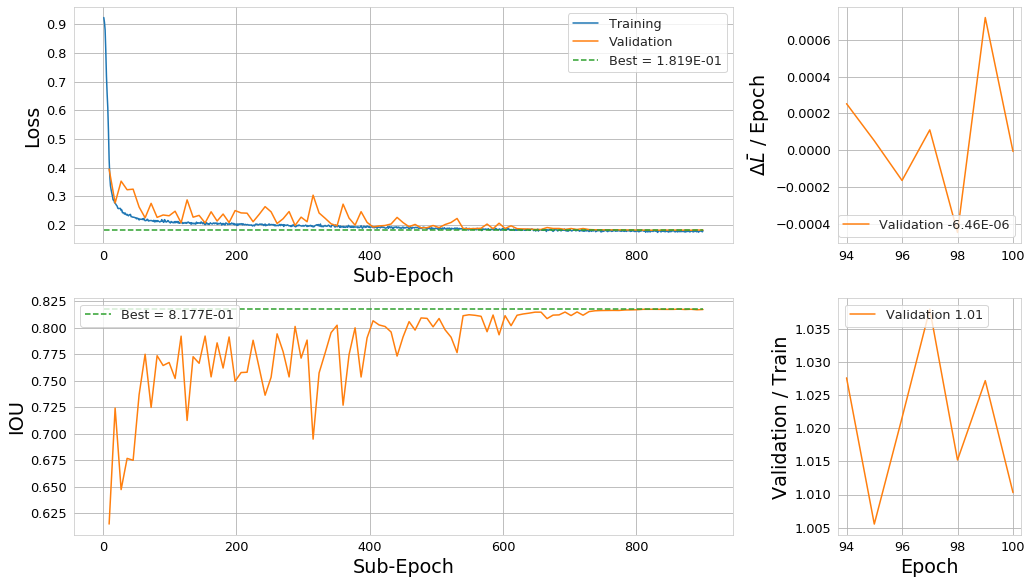

Loading best model with metric value -8.177E-01
Model took 5293.361s

Scores are: {'loss': 0.18222747304860284, 'IOU': 0.81774160599855}
Training model 3 / 5, Valid Index = 2, Train indices= [0, 1, 3, 4, 5, 6, 7, 8, 9]


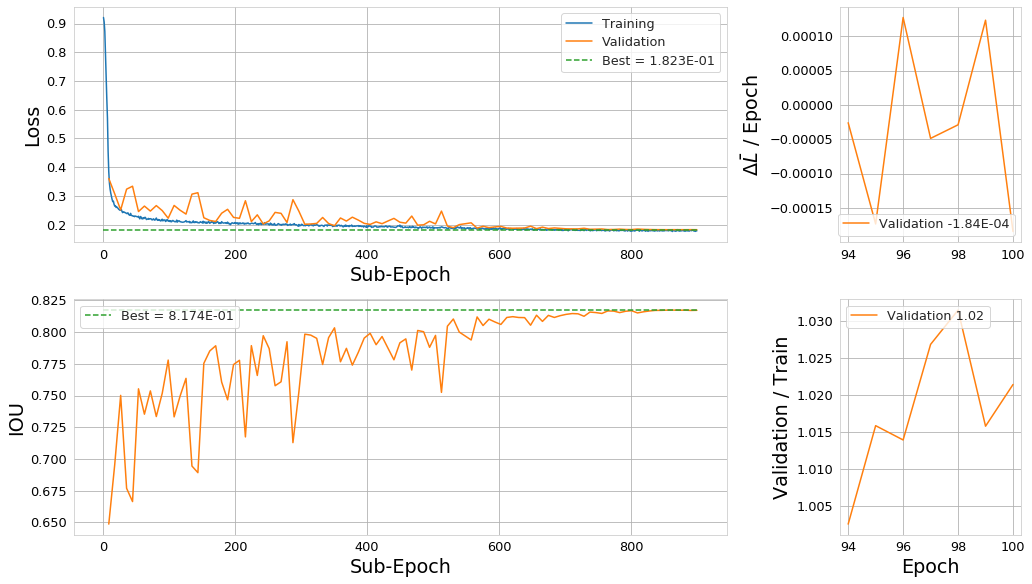

Loading best model with metric value -8.174E-01
Model took 5295.725s

Scores are: {'loss': 0.1824848161024206, 'IOU': 0.8173932696129986}
Training model 4 / 5, Valid Index = 3, Train indices= [0, 1, 2, 4, 5, 6, 7, 8, 9]


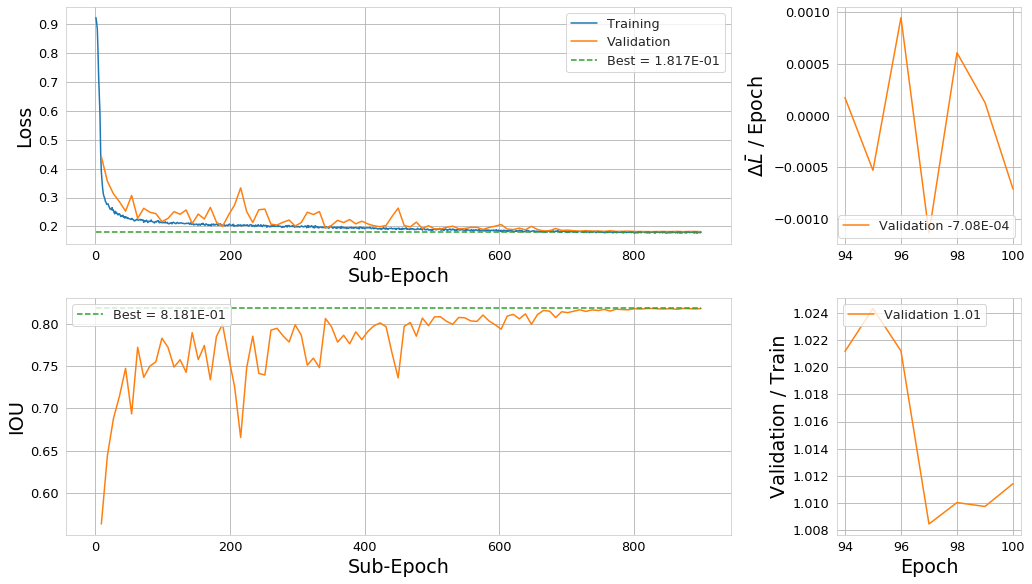

Loading best model with metric value -8.181E-01
Model took 5297.277s

Scores are: {'loss': 0.18172571764272802, 'IOU': 0.8180958927219495}
Training model 5 / 5, Valid Index = 4, Train indices= [0, 1, 2, 3, 5, 6, 7, 8, 9]


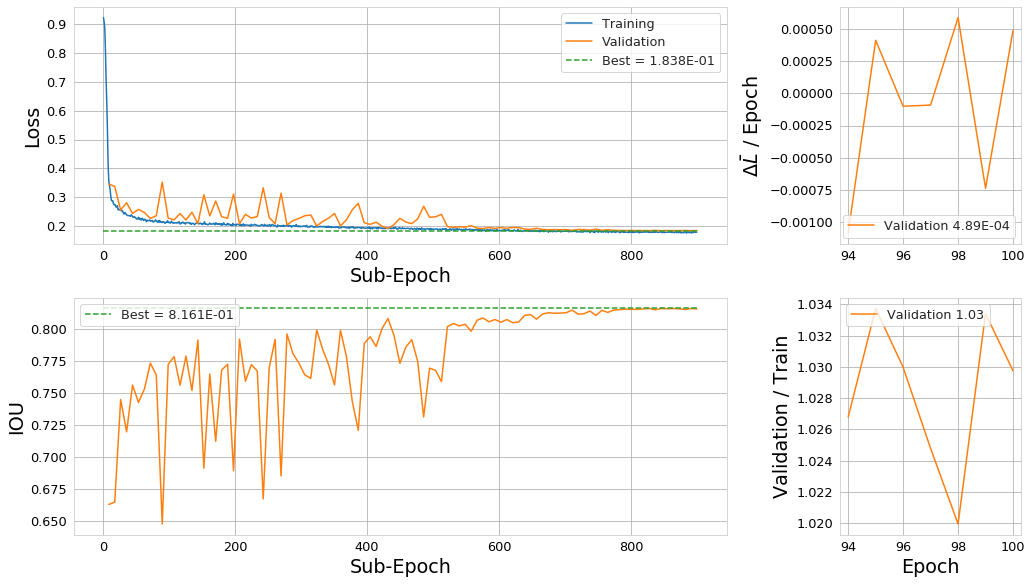

Loading best model with metric value -8.161E-01
Model took 5280.376s

Scores are: {'loss': 0.18381941669127522, 'IOU': 0.8160869345132341}

______________________________________
Training finished
Cross-validation took 26473.434s 


<Figure size 1024x576 with 0 Axes>

<Figure size 1024x576 with 0 Axes>

<Figure size 1024x576 with 0 Axes>

<Figure size 1024x576 with 0 Axes>

<Figure size 1024x576 with 0 Axes>

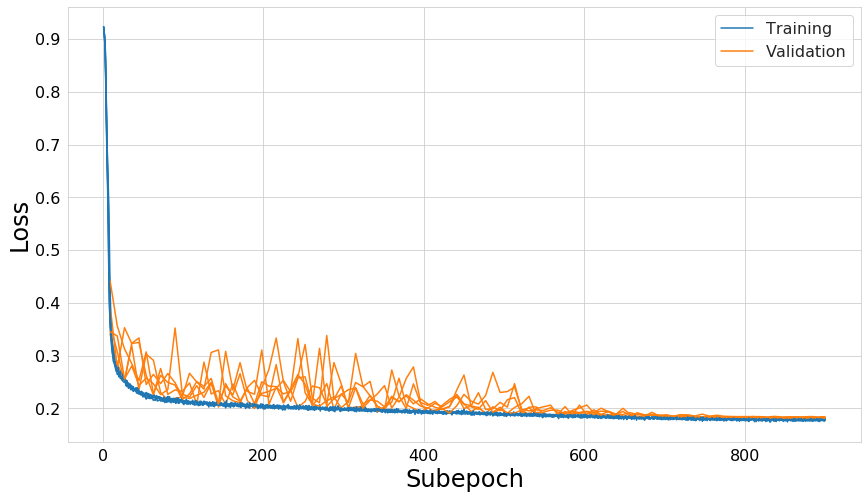

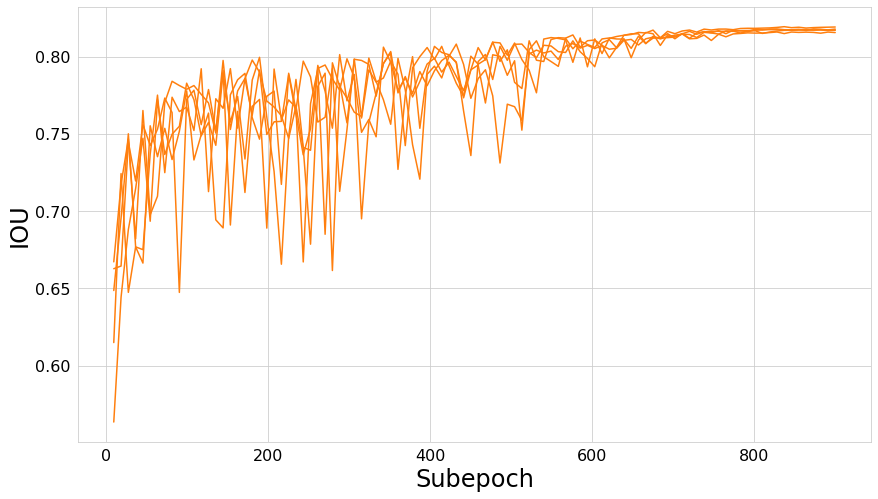

Mean loss = 0.1822±0.0005
Mean IOU = 0.8178±0.0005
______________________________________



In [20]:
results = train_models(train_fy, n_models=5,
                 model_builder=model_builder,
                 bs=bs,
                 cb_partials=cb_partials,
                 metric_partials=metric_partials,
                 bulk_move=False,
                 n_epochs=n_epochs, savepath=Path(f'train_weights_{GPUID}'))

## Validation
Load and save trained models

In [ ]:
results

In [21]:
model = Ensemble.from_results(results[0], size=5, model_builder=model_builder)

Choosing ensemble by loss


Model 0 is 0 with loss = 0.18054629949962392
Model 1 is 3 with loss = 0.18172571764272802
Model 2 is 1 with loss = 0.18222747304860284
Model 3 is 2 with loss = 0.1824848161024206
Model 4 is 4 with loss = 0.18381941669127522


In [22]:
model.save('weights/unet-pixelshuffle_depth-encode_data-aug_gravnet_osa_f32_full-long_ensemble5/full')

In [17]:
model = Ensemble.from_save('weights/unet-pixelshuffle_depth-encode_data-aug_gravnet_osa_f32_full-long_ensemble5/full')

In [21]:
model.weights = np.ones_like(model.weights)/5

### No Aug
Check IOU without data-aug

In [24]:
val_fy = FoldYielder(PATH/'valid_lumin_full.hdf5')

In [25]:
preds = model.predict(val_fy.get_column('matrix_inputs'), bs=512)

In [26]:
targs = val_fy.get_column('targets')

In [26]:
binary_iou(preds>=0.5, targs)

0.8207807305998168

In [27]:
ious = binary_iou(preds>=0.5, targs, as_mean=False)
ious

array([[0.77941176],
       [0.73684211],
       [0.72463768],
       ...,
       [0.78125   ],
       [0.84      ],
       [0.81481481]])

In [28]:
cuts = np.arange(0.5,1,0.05)
sample_scores = ious>=cuts
sample_scores.shape

(21226, 10)

In [29]:
sample_scores.mean(), ((sample_scores*cuts).sum(1)/(cuts.sum())).mean()

(0.6876896259304627, 0.6353788619682432)

### Test Aug
Check score with test-time data aug

In [18]:
val_fy = AugFoldYielder(PATH/'valid_lumin_full.hdf5')

Take mean prediction over each augmentation, for each model, after mapping predictions back to original view

In [20]:
def get_aug_preds(fy:AugFoldYielder, model:Union[Model, Ensemble], bs:Optional[int]=512) -> np.ndarray:
    preds = []
    for aug in (mb:=master_bar(range(fy.aug_mult))):
        fpreds = []
        for fld in progress_bar(range(len(fy)), parent=mb):
            fpreds.append(model.predict(fy.get_test_fold(fld, aug)['inputs'], bs=bs))

        fpreds = np.vstack(fpreds).reshape(-1,*fy.matrix_shape)
        if aug >= 4: fpreds = np.flip(fpreds, -2)
        fpreds = np.rot90(fpreds, -(aug%4), (-1,-2))

        preds.append(fpreds.reshape(len(fpreds), -1))
    return np.mean(preds, 0)

In [21]:
preds = get_aug_preds(val_fy, model[0][1])

In [22]:
targs = val_fy.get_column('targets')

In [23]:
binary_iou((preds>=0.5).astype('int'), targs)

0.8204553613067352

In [42]:
preds = get_aug_preds(val_fy, model)

In [43]:
targs = val_fy.get_column('targets')

In [62]:
binary_iou((preds>=0.5).astype('int'), targs)

0.8214998380409548

In [39]:
ious = binary_iou(preds>=0.5, targs, as_mean=False)
ious

array([[0.77941176],
       [0.76712329],
       [0.71014493],
       ...,
       [0.6875    ],
       [0.86      ],
       [0.81481481]])

In [40]:
cuts = np.arange(0.5,1,0.05)
sample_scores = ious>=cuts
sample_scores.shape

(21226, 10)

In [41]:
sample_scores.mean(), ((sample_scores*cuts).sum(1)/(cuts.sum())).mean()

(0.6889428059926506, 0.6368308872982711)

In [42]:
def plot_preds(x0:np.ndarray, targ:np.ndarray, cut:float=0.5) -> None:
    n_layers = x0.shape[0]
    fig, axs = plt.subplots(3, n_layers, figsize=(10*16/9, 8))

    for layer in range(n_layers-1,-1,-1):
        sns.heatmap(x0[layer], ax=axs[0,n_layers-layer-1], vmin=np.nanmin(x0), vmax=np.nanmax(x0), cbar=None, square=True, cmap='viridis')
        sns.heatmap(x0[layer]>=cut, ax=axs[1,n_layers-layer-1], vmin=0, vmax=1, cbar=None, square=True, cmap='viridis')
        sns.heatmap(targ[layer], ax=axs[2,n_layers-layer-1], vmin=0, vmax=1, cbar=None, square=True, cmap='viridis')
        axs[1,n_layers-layer-1].set_xlabel(f"Layer {layer}")
    axs[0,0].set_ylabel("Output")
    axs[1,0].set_ylabel("Pred class")
    axs[2,0].set_ylabel("Target class")
    plt.show()

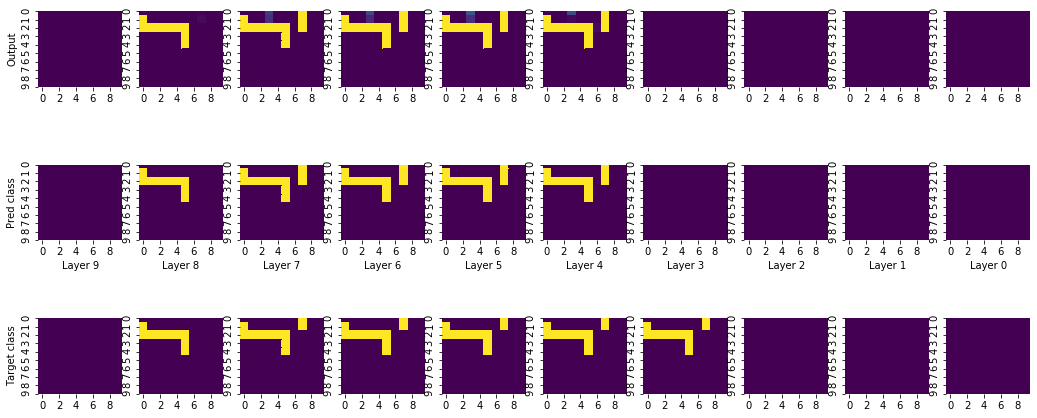

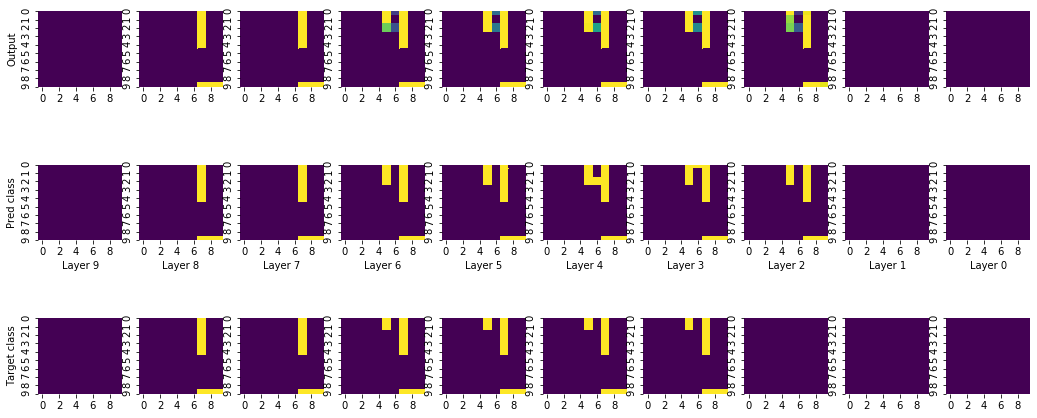

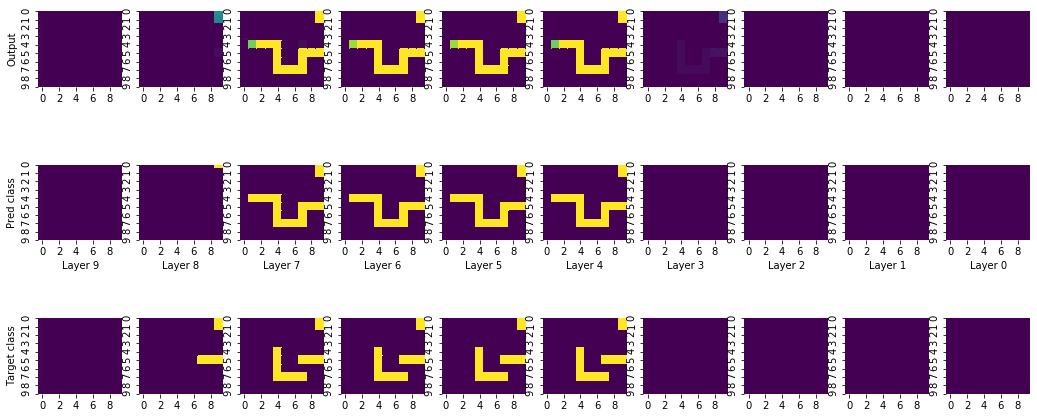

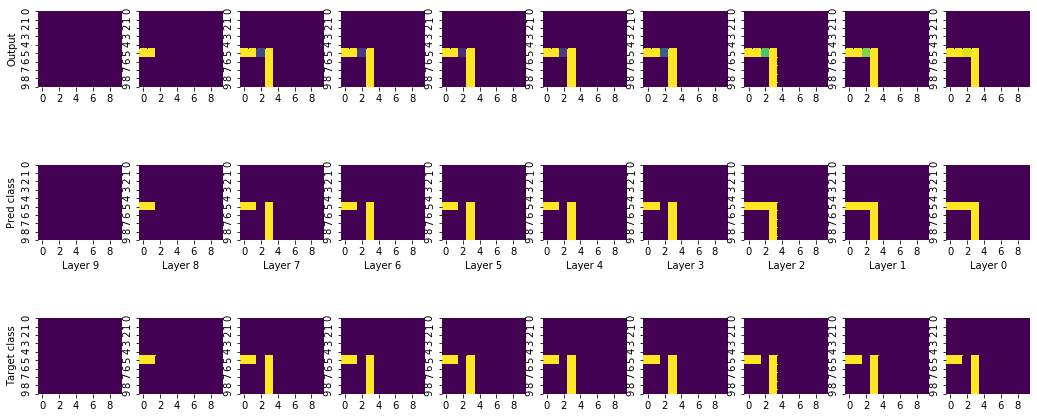

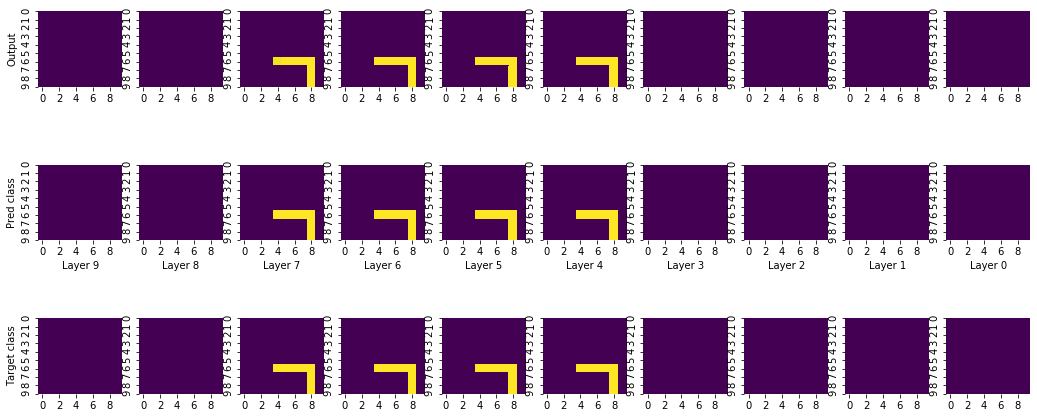

In [43]:
for idx in range(5):
    plot_preds(preds[idx].reshape(10,10,10), targs[idx].reshape(10,10,10))

## Threshold opt
Check to see if threshold optimising helps

In [45]:
preds.shape

(21226, 1000)

In [46]:
opt_preds, opt_targs = preds[:10000], targs[:10000]
val_preds, val_targs = preds[10000:], targs[10000:]

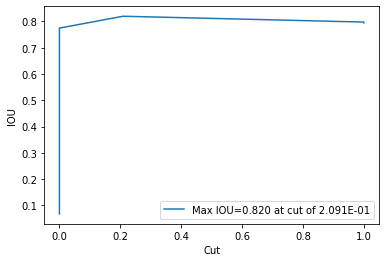

In [48]:
x,y = [0],[binary_iou(opt_preds>=0, opt_targs)]
for p in progress_bar(range(0,100)):
    x.append(np.percentile(opt_preds, p))
    y.append(binary_iou(opt_preds>=x[-1], opt_targs))

max_iou = np.max(y)
cut = x[np.argmax(y)]
plt.plot(x,y, label=f'Max IOU={max_iou:.3f} at cut of {x[np.argmax(y)]:.3E}')
plt.ylabel('IOU')
plt.xlabel('Cut')
plt.legend()

No, just stick with pred >= 0.5

## Zero top layer
Top layer always soil. Could hardcode to zero, model learns this anyway

In [64]:
preds[:,-1].max()

3.657396406205146e-05

# Test sub

In [65]:
tst_fy = AugFoldYielder(PATH/'test_lumin.hdf5')

In [66]:
tst_preds = get_aug_preds(tst_fy, model, bs=512)

In [67]:
tst_preds.shape

(30036, 1000)

In [68]:
class_preds = (tst_preds>0.5).astype('int').reshape(len(tst_preds),10,10,10)

In [69]:
class_preds

array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        ...,

        [[0, 0, 0, ..., 0, 0, 1],
         [0, 0, 0, ..., 0, 0, 1],
         [0, 0, 0, ..., 1, 0, 1],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 1],
         [0, 0, 0, ..., 0, 0, 1],
         [0, 0, 0, ..., 1, 0, 1],
    

In [70]:
class_preds.shape

(30036, 10, 10, 10)

In [71]:
with h5py.File(f'GILES_STRONG_ID03_test_preds.h5', 'w') as h5:
    h5.create_dataset("preds", data=class_preds.astype("int"), dtype="int", compression='lzf')